In [1]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, datasets, metrics
from sklearn.metrics import classification_report
import keras
import tensorflow
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from joblib import dump, load

Using TensorFlow backend.


In [2]:
train_data=pd.read_csv("fashion-mnist_train.csv")
test_data=pd.read_csv("fashion-mnist_test.csv")

In [3]:
train_data = np.array(train_data, dtype = 'float32')
test_data=np.array(test_data, dtype = 'float32')

train_X=train_data[:,1:]/255
train_y=train_data[:,0]

test_X=test_data[:,1:]/255
test_y=test_data[:,0]

from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val =train_test_split(train_X,train_y,test_size=0.3,random_state=42)
n_classes = 10
# targets sets to categorical
Y_train = keras.utils.to_categorical(y_train, n_classes)
Y_val = keras.utils.to_categorical(y_val, n_classes)

In [35]:
y_train

array([9., 8., 4., ..., 9., 4., 0.], dtype=float32)

In [10]:
# SMV with kernel trick 
def fit_predict_score(name,clf):
    classifier=clf
    clf.fit(train_X, train_y)
    predicted = clf.predict(test_X)
    confusion_matrix =  pd.crosstab(index=test_y, columns=predicted.ravel(), 
                                    rownames=['Expected'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True, square=False, fmt='', cbar=False)
    accuracy = np.round(metrics.accuracy_score(test_y , predicted),3)
    plt.title(name + ", Accuracy: " + str(accuracy), fontsize = 15)
    plt.show()
    print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(test_y, predicted)))

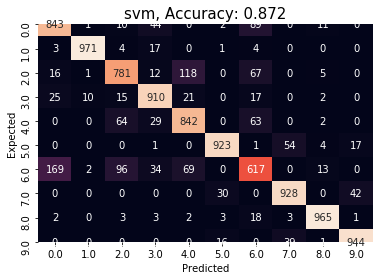

Classification report for classifier SVC(C=5.0, gamma=0.001):
              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      1000
         1.0       0.99      0.97      0.98      1000
         2.0       0.80      0.78      0.79      1000
         3.0       0.87      0.91      0.89      1000
         4.0       0.80      0.84      0.82      1000
         5.0       0.95      0.92      0.93      1000
         6.0       0.70      0.62      0.66      1000
         7.0       0.91      0.93      0.92      1000
         8.0       0.96      0.96      0.96      1000
         9.0       0.94      0.94      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000




In [11]:
fit_predict_score("svm",svm.SVC(C=5., gamma=0.001))

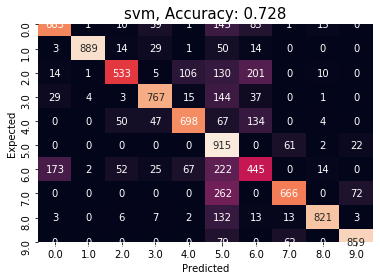

Classification report for classifier SVC(C=5.0, gamma=0.001, kernel='poly'):
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.72      1000
         1.0       0.99      0.89      0.94      1000
         2.0       0.80      0.53      0.64      1000
         3.0       0.82      0.77      0.79      1000
         4.0       0.78      0.70      0.74      1000
         5.0       0.43      0.92      0.58      1000
         6.0       0.48      0.45      0.46      1000
         7.0       0.83      0.67      0.74      1000
         8.0       0.95      0.82      0.88      1000
         9.0       0.90      0.86      0.88      1000

    accuracy                           0.73     10000
   macro avg       0.77      0.73      0.74     10000
weighted avg       0.77      0.73      0.74     10000




In [15]:
fit_predict_score("svm",svm.SVC(C=5., gamma=0.001,kernel='poly'))

In [ ]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier


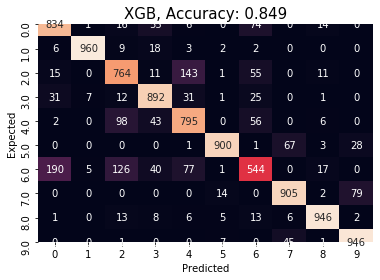

Classification report for classifier               precision    recall  f1-score   support

         0.0       0.77      0.83      0.80      1000
         1.0       0.99      0.96      0.97      1000
         2.0       0.74      0.76      0.75      1000
         3.0       0.84      0.89      0.86      1000
         4.0       0.75      0.80      0.77      1000
         5.0       0.97      0.90      0.93      1000
         6.0       0.71      0.54      0.61      1000
         7.0       0.88      0.91      0.89      1000
         8.0       0.95      0.95      0.95      1000
         9.0       0.90      0.95      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000
:


In [22]:
# xbgoost
import xgboost as xgb

D_train = xgb.DMatrix(train_X, label=train_y)
D_test = xgb.DMatrix(test_X, label=test_y)

param = {
    'eta': 0.1, 
    'max_depth': 5,  
    'objective': 'multi:softprob',  
    'num_class': 10} 

steps = 20

model_xgb = xgb.train(param, D_train, steps)
preds_xgb = model_xgb.predict(D_test)

best_preds = np.asarray([np.argmax(line) for line in preds_xgb])
best_preds
confusion_xgb_matrix =  pd.crosstab(index=test_y, columns=best_preds.ravel(), 
                                    rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_xgb_matrix, annot=True, square=False, fmt='', cbar=False)
accuracy_xgb = np.round(metrics.accuracy_score(test_y , best_preds),3)
plt.title("XGB" + ", Accuracy: " + str(accuracy_xgb), fontsize = 15)
plt.show()
print("Classification report for classifier %s:"
 % (metrics.classification_report(test_y, best_preds)))

In [18]:
# building a linear stack of layers with the sequential model
model_NN = Sequential()
# hidden layer
model_NN.add(Dense(200, input_shape=(784,), activation='relu'))
model_NN.add(Dense(150, activation='relu',kernel_regularizer=l2(0.01)))
model_NN.add(Dense(110, activation='relu'))
model_NN.add(Dense(50, activation='relu'))
model_NN.add(Dropout(0.2)) # avoid overfitting
model_NN.add(Dense(10, activation='softmax'))

model_NN.summary()
model_NN.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# training the model for 100 epochs
history_NN=model_NN.fit(X_train, Y_train, batch_size=128, epochs=100, validation_data=(X_val, Y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_3 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_4 (Dense)              (None, 110)               16610     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
Total params: 209,820
Trainable params: 209,820
Non-trainable params: 0
________________________________________________

In [ ]:
# persist model 
#dump(history_NN, 'Neural_Network.joblib') 
# history_CNN= load('history_NN.joblib')

Text(0.5, 1.0, 'Loss Curves')

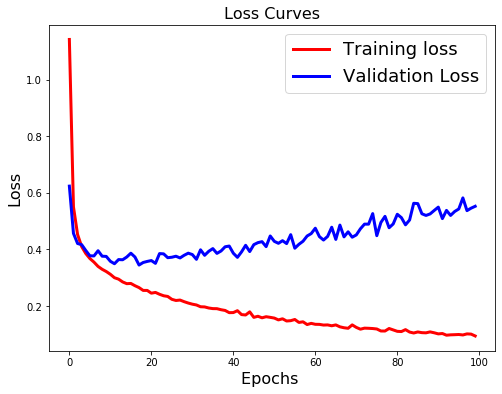

In [19]:
# loss curve 
plt.figure(figsize=[8,6])
plt.plot(history_NN.history['loss'],'r',linewidth=3.0)
plt.plot(history_NN.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

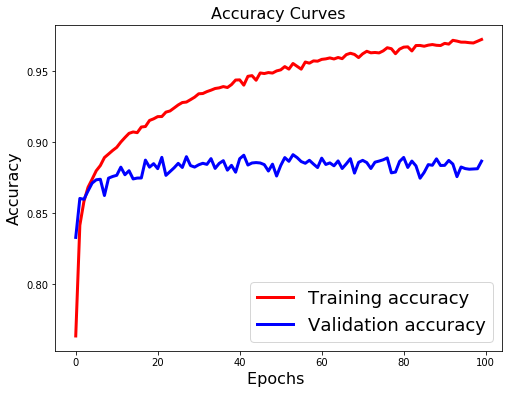

In [20]:
# accuracy curve 
plt.figure(figsize=[8,6])
plt.plot(history_NN.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_NN.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training accuracy', 'Validation accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

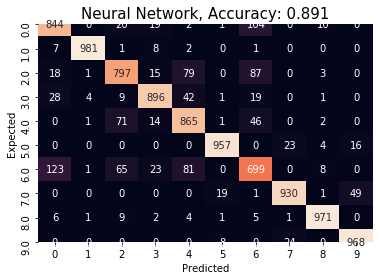

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83      1000
         1.0       0.99      0.98      0.99      1000
         2.0       0.82      0.80      0.81      1000
         3.0       0.92      0.90      0.91      1000
         4.0       0.80      0.86      0.83      1000
         5.0       0.97      0.96      0.96      1000
         6.0       0.73      0.70      0.71      1000
         7.0       0.95      0.93      0.94      1000
         8.0       0.97      0.97      0.97      1000
         9.0       0.94      0.97      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [21]:
predict_NN_class=model_NN.predict_classes(test_X)
confusion_matrix_NN =  pd.crosstab(index=test_y, columns=predict_NN_class.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_NN, annot=True, square=False, fmt='', cbar=False)
accuracy = np.round(metrics.accuracy_score(test_y , predict_NN_class),3)
plt.title("Neural Network" + ", Accuracy: " + str(accuracy), fontsize = 15)
plt.show()
print(classification_report(test_y, predict_NN_class))

In [4]:
# convert data to image shape for CNN 
img_rows=28
img_cols=28
# for train & validation 
if K.image_data_format() == 'channels_first':
    X_train_CNN = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_val_CNN = X_val.reshape(X_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train_CNN = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_val_CNN = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [5]:
# for test 
if K.image_data_format() == 'channels_first':
    test_X_CNN = test_X.reshape(test_X.shape[0], 1, img_rows, img_cols)
    
else:
    test_X_CNN = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
   

In [6]:
X_train_CNN.shape,X_val_CNN.shape,test_X_CNN.shape

((42000, 28, 28, 1), (18000, 28, 28, 1), (10000, 28, 28, 1))

In [7]:
## CNN
model_CNN = Sequential()
model_CNN.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows, img_cols,1)))
model_CNN.add(BatchNormalization())
model_CNN.add(Conv2D(32, (2, 2), activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN.add(Dropout(0.25))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.25))
model_CNN.add(Dense(n_classes, activation='softmax'))

In [8]:
model_CNN.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        8224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [9]:
history_CNN = model_CNN.fit(X_train_CNN, Y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data=(X_val_CNN, Y_val)) 

Train on 42000 samples, validate on 18000 samples
Epoch 1/50
42000/42000 [==============================] - 53s 1ms/sample - loss: 0.5390 - accuracy: 0.8094 - val_loss: 1.4008 - val_accuracy: 0.8539
Epoch 2/50
42000/42000 [==============================] - 55s 1ms/sample - loss: 0.3512 - accuracy: 0.8745 - val_loss: 0.3158 - val_accuracy: 0.8936
Epoch 3/50
42000/42000 [==============================] - 52s 1ms/sample - loss: 0.3010 - accuracy: 0.8905 - val_loss: 0.2748 - val_accuracy: 0.8952
Epoch 4/50
42000/42000 [==============================] - 55s 1ms/sample - loss: 0.2734 - accuracy: 0.9004 - val_loss: 0.2569 - val_accuracy: 0.9078
Epoch 5/50
42000/42000 [==============================] - 52s 1ms/sample - loss: 0.2432 - accuracy: 0.9095 - val_loss: 0.2581 - val_accuracy: 0.9056
Epoch 6/50
42000/42000 [==============================] - 51s 1ms/sample - loss: 0.2243 - accuracy: 0.9154 - val_loss: 0.2612 - val_accuracy: 0.9048
Epoch 7/50
42000/42000 [==============================] 

In [ ]:
# persist model 
#dump(history_CNN, 'CNN.joblib') 
# history_CNN= load('CNN.joblib')

Text(0.5, 1.0, 'Loss Curves')

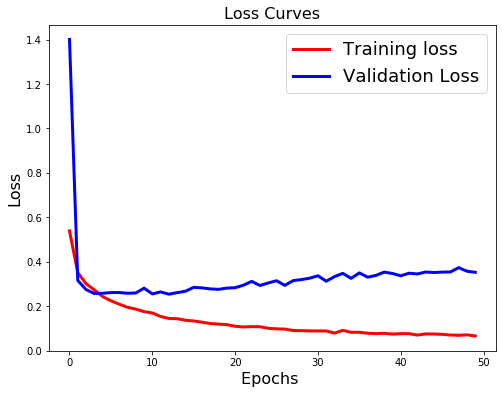

In [10]:
# loss curve 
plt.figure(figsize=[8,6])
plt.plot(history_CNN.history['loss'],'r',linewidth=3.0)
plt.plot(history_CNN.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

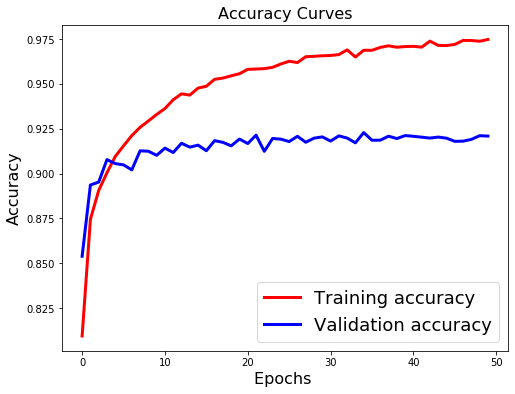

In [11]:
# accuracy curve 
plt.figure(figsize=[8,6])
plt.plot(history_CNN.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_CNN.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training accuracy', 'Validation accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

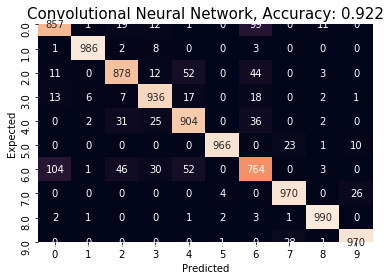

              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      1000
         1.0       0.99      0.99      0.99      1000
         2.0       0.89      0.88      0.89      1000
         3.0       0.91      0.94      0.93      1000
         4.0       0.88      0.90      0.89      1000
         5.0       0.99      0.97      0.98      1000
         6.0       0.79      0.76      0.78      1000
         7.0       0.95      0.97      0.96      1000
         8.0       0.98      0.99      0.98      1000
         9.0       0.96      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [12]:
predict_CNN_class=model_CNN.predict_classes(test_X_CNN)
confusion_matrix_CNN =  pd.crosstab(index=test_y, columns=predict_CNN_class.ravel(), rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(confusion_matrix_CNN, annot=True, square=False, fmt='', cbar=False)
CNN_accuracy = np.round(metrics.accuracy_score(test_y , predict_CNN_class),3)
plt.title("Convolutional Neural Network" + ", Accuracy: " + str(CNN_accuracy), fontsize = 15)
plt.show()
print(classification_report(test_y, predict_CNN_class))


score_CNN = model_CNN.evaluate(test_X_CNN, test_y, verbose=0)
print('Test loss:', score_CNN[0])
print('Test accuracy:', score_CNN[1])


In [9]:
# adding with data generator to rotate training pictures 
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train_CNN, Y_train, batch_size=256)
val_batches = gen.flow(X_val_CNN, Y_val, batch_size=256)

In [10]:
history_CNN_Gen = model_CNN.fit_generator(batches, steps_per_epoch=42000//256, epochs=50,
                    validation_data=val_batches, validation_steps=18000//256, use_multiprocessing=False)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 164 steps, validate for 70 steps
Epoch 1/50
164/164 [==============================] - 58s 351ms/step - loss: 0.8397 - accuracy: 0.6953 - val_loss: 1.8653 - val_accuracy: 0.7435
Epoch 2/50
164/164 [==============================] - 58s 356ms/step - loss: 0.5800 - accuracy: 0.7840 - val_loss: 1.2956 - val_accuracy: 0.8007
Epoch 3/50
164/164 [==============================] - 57s 348ms/step - loss: 0.5205 - accuracy: 0.8066 - val_loss: 0.7436 - val_accuracy: 0.8172
Epoch 4/50
164/164 [==============================] - 65s 396ms/step - loss: 0.4827 - accuracy: 0.8183 - val_loss: 0.4620 - val_accuracy: 0.8364
Epoch 5/50
164/164 [==============================] - 64s 392ms/step - loss: 0.4618 - accuracy: 0.8280 - val_loss: 0.4065 - val_accuracy: 0.8482
Epoch 6/50
164/164 [==============================] - 61s 373ms/step - loss: 0.4393 - accuracy: 0.8360 - v

Text(0.5, 1.0, 'Loss Curves')

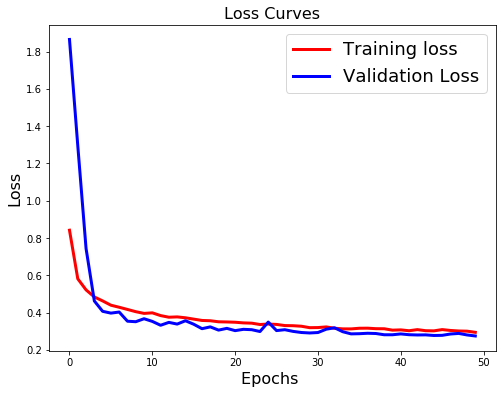

In [11]:
# loss curve 
plt.figure(figsize=[8,6])
plt.plot(history_CNN_Gen.history['loss'],'r',linewidth=3.0)
plt.plot(history_CNN_Gen.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

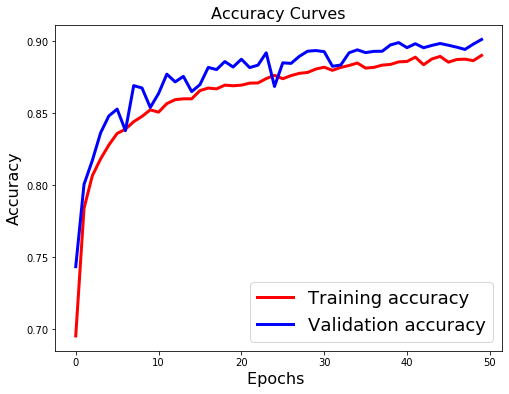

In [12]:
# accuracy curve 
plt.figure(figsize=[8,6])
plt.plot(history_CNN_Gen.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_CNN_Gen.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training accuracy', 'Validation accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)